In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

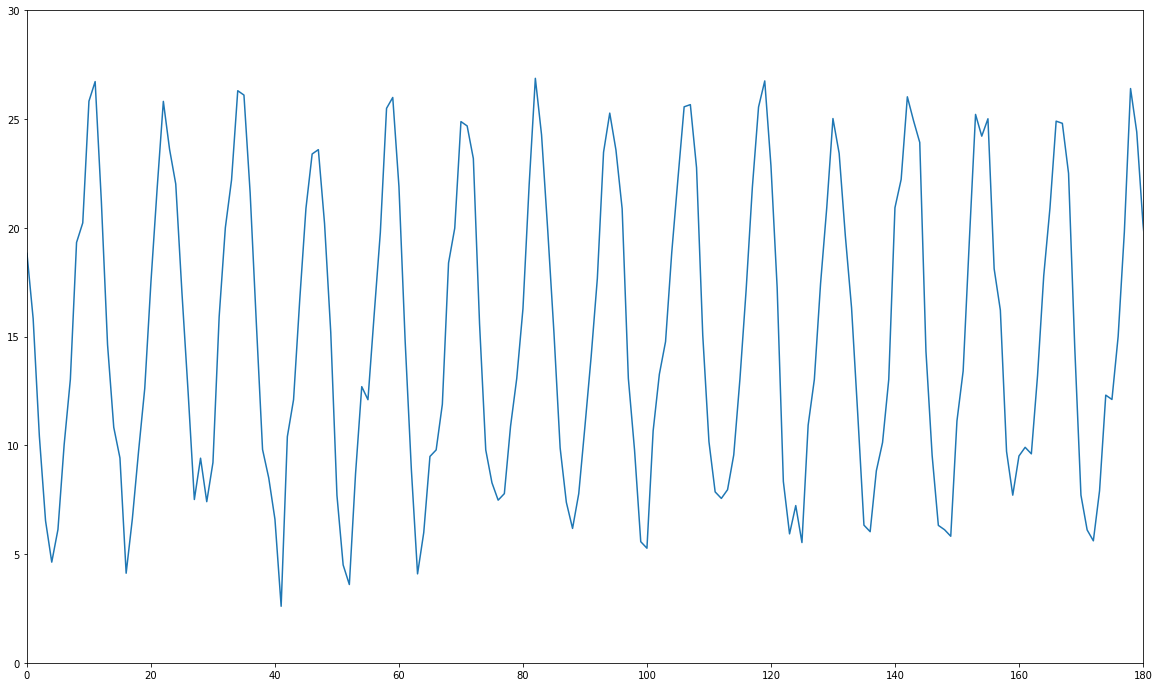

In [3]:
dataframe = pandas.read_csv('data/station.csv', usecols=[1,2,3,4,5,6,7,8,9,10,11,12], engine='python', skiprows=0)
# Map sentinels to a sensible value
dataframe = dataframe.replace(999.90, 7)
# Reshape to sequence of monthly temperatures
dataset = dataframe.values.reshape(np.prod(dataframe.shape), 1)
# Remove first 8 values (sentinels)
dataset = dataset[8:] 

# Plot 20 years
plt.rcParams['figure.figsize'] = (20.0, 12.0)
plt.plot(dataset)
plt.axis([0,15 * 12,0,30])
plt.show()

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX = [dataset[i:i+look_back] for i in range(0, len(dataset) - look_back)]
    dataY = [dataset[i] for i in range(look_back, len(dataset))]
    return np.array(dataX), np.array(dataY)

In [12]:
# reshape into X=t and Y=t+1
look_back = 6
validation_split = 0.3
X,Y = create_dataset(dataset, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41.0
Trainable params: 41
Non-trainable params: 0.0
_________________________________________________________________


In [13]:
train_size = int(len(X) * (1 - validation_split))
test_size = len(X) - train_size
[trainX, testX] = np.array_split(X, [train_size])
[trainY, testY] = np.array_split(Y, [train_size])

# reshape input to be [samples, time steps, features]
# trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Simplified...
# trainX, testX = X[0:train_size, :], X[train_size:len(dataset), :]

# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(5, input_shape=(None, 1), activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41.0
Trainable params: 41
Non-trainable params: 0.0
_________________________________________________________________


In [18]:
batch_size = 1
epochs = 10
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, shuffle=False, verbose=2)

Train on 527 samples, validate on 227 samples
Epoch 1/10


2s - loss: 0.0043 - val_loss: 0.0032
Epoch 2/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 3/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 4/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 5/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 6/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 7/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 8/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 9/10


2s - loss: 0.0042 - val_loss: 0.0031
Epoch 10/10


2s - loss: 0.0041 - val_loss: 0.0031


In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict_t = scaler.inverse_transform(trainPredict)
trainY_t = scaler.inverse_transform(trainY)
testPredict_t = scaler.inverse_transform(testPredict)
testY_t = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_t, trainPredict_t[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_t, testPredict_t[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.99 RMSE
Test Score: 1.53 RMSE


In [20]:
from collections import deque
futurePredictions = []
lastPrediction = testPredict[0]
# print('Last prediction: ')
# print(lastPrediction)
futurePredictions.append(lastPrediction)
# print('Future predictions: ')
# print(futurePredictions)
# print('Last training X:')
# print(trainX[-1])
dq = deque(testX[0].copy())
futureXs = []

for i in range(testY_t.size - 1):
    dq.popleft()
    dq.append(lastPrediction)
    futureX = np.reshape(dq, (1, look_back, 1))
    futureXs = np.reshape(np.append(futureXs, futureX), (i + 1, look_back, 1))
    lastPrediction = model.predict(futureXs)[-1][0]
    futurePredictions.append(lastPrediction)
    # print('Last prediction: ')
    # print(lastPrediction)
    # print('Future predictions: ')
    # print(futurePredictions)

futurePredict_t = scaler.inverse_transform([futurePredictions])
futurePredict_t = np.reshape(futurePredict_t, testPredict_t.shape)
# print(testPredict_t)
# print(futurePredict_t)
# print(np.hstack((np.reshape(testY_t, testPredict_t.shape), testPredict_t, futurePredict_t)))
futScore = math.sqrt(mean_squared_error(testY_t[0], futurePredict_t[0]))
print('Future Score: %.2f RMSE' % (futScore))

Future Score: 0.66 RMSE


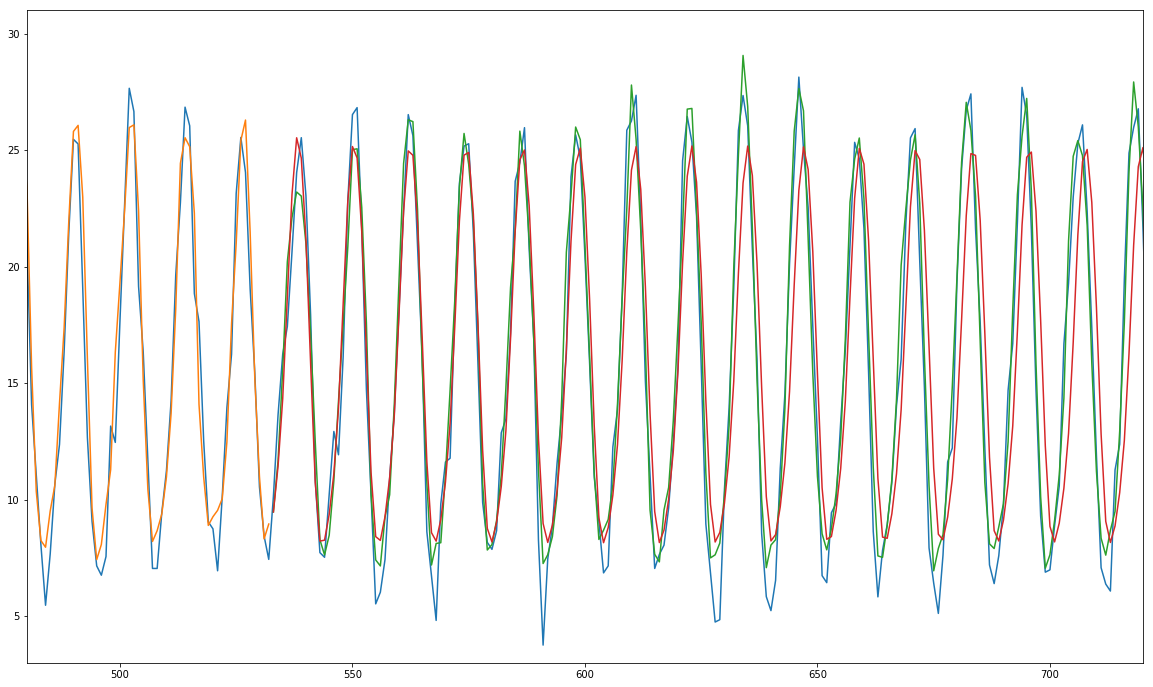

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_t)+look_back, :] = trainPredict_t
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict_t):, :] = testPredict_t
# shift future predictions for plotting
futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot[-len(futurePredict_t):, :] = futurePredict_t

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(futurePredictPlot)
start_year = 40
years = 20
plt.axis([start_year * 12,(start_year + years) * 12,3,31])
plt.show()

In [16]:
history.history

{'loss': [0.033730829515138977,
  0.020724923240225648,
  0.019978920760906918,
  0.019934917528466375,
  0.019939098458952413,
  0.019943084088488244,
  0.019945025521874587,
  0.019945625493960104,
  0.019945433348064309,
  0.019944778125666425],
 'val_loss': [0.022253023906127885,
  0.019887257239936566,
  0.019629793192505355,
  0.019596689925338483,
  0.019590781194553205,
  0.019589529681866225,
  0.019589234565580382,
  0.019589150045035558,
  0.019589108235828389,
  0.019589084974365022]}

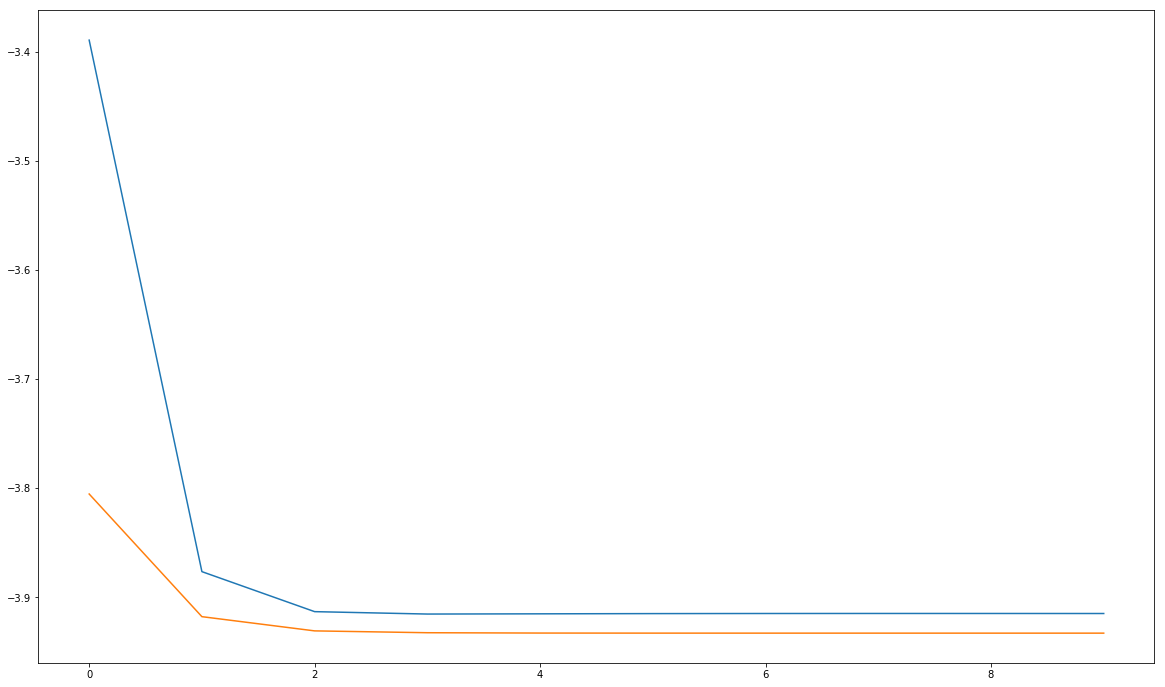

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [26]:
model.get_weights()

[array([[ 0.58538359, -0.02700114, -0.93438196, -0.82649988, -1.11737907]], dtype=float32),
 array([[ 0.31455931,  0.60889232,  0.28919694,  0.60640675, -0.01986027],
        [-0.41618291,  0.60235727,  0.19537129, -0.46983445,  0.59903139],
        [ 0.15893713,  0.50559062,  0.14776747, -0.69206601, -0.76714563],
        [ 0.12699091, -0.44790238,  0.95886397, -0.2985442 ,  0.40377936],
        [ 0.86409563,  0.23547202, -0.40227506, -0.33896109,  0.46305552]], dtype=float32),
 array([ 0.01663056, -0.01600019,  0.28345814,  0.02423389, -0.14599548], dtype=float32),
 array([[-0.60631353],
        [-0.8546021 ],
        [-0.81504017],
        [-0.40180594],
        [ 0.45152479]], dtype=float32),
 array([ 0.08946281], dtype=float32)]